# Import libraries 

In [1]:
# Jax dedicated libraries
from flax import nnx
import optax
import jax
import jax.numpy as jnp # From this point on, there should not be numpy anymore but only jax.numpy
import jax.scipy as jsp

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Module functions
import ximinf.nn_train as nntr
import ximinf.nn_test as nnte

# Other
from IPython.display import clear_output
import h5py

# Set seed

In [2]:
key = jax.random.PRNGKey(42)

W0000 00:00:1764679618.751165 1398961 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1764679618.794005 1398961 service.cc:145] XLA service 0x7f9807f8b9f0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764679618.794024 1398961 service.cc:153]   StreamExecutor device (0): Metal, <undefined>


Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 3.99 GB



I0000 00:00:1764679619.719496 1398961 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1764679619.719521 1398961 mps_client.cc:384] XLA backend will use up to 8572612608 bytes on device 0 for SimpleAllocator.


# Set device type

In [3]:
cpu = jax.devices("cpu")[0]
gpu = jax.devices("METAL")[0]
jax.default_device(gpu)
print(jax.default_backend())

METAL


# Import training data

In [4]:
# Path to the new HDF5 file
file_path = "../data/SIM/simulations_10000_400_nosel.h5"

with h5py.File(file_path, "r") as f:
    # Parameters: load directly as (N,) JAX arrays
    params = {key: jnp.array(f[f"params/{key}"][:]) for key in f["params"].keys()}

    # Data columns: load directly as (N, M) JAX arrays
    data = {col: jnp.array(f[f"data/{col}"][:]) for col in f["data"].keys()}


# Number of simulations and SNe per simulation
N = next(iter(params.values())).shape[0]   # N simulations
M = next(iter(data.values())).shape[1]     # M SNe per simulation

print(f"The file contains {N} simulations of size {M}")

The file contains 10000 simulations of size 400


In [5]:
magobs = data["magobs"]      # (N,M)
mask = magobs != 0           # (N,M)

# Apply mask
# Masked version (NaNs)
data_filt = {k: jnp.where(mask, v, jnp.nan) for k, v in data.items()}

# Padded version (zeros)
data_padded = {k: jnp.where(mask, v, 0) for k, v in data.items()}

# Example usage
print(params['alpha'].shape)   # (N,)
print(data['magobs'].shape)    # (N, M)

(10000,)
(10000, 400)


# Compute residuals

In [6]:
mu_planck18, data_filt['magobs'], params['mabs'] = nntr.rm_cosmo(data_filt['z'], data_filt['magobs'], params['mabs'])

Building Planck18 interpolation...
... done
Interpolating mu for dataset...
... done


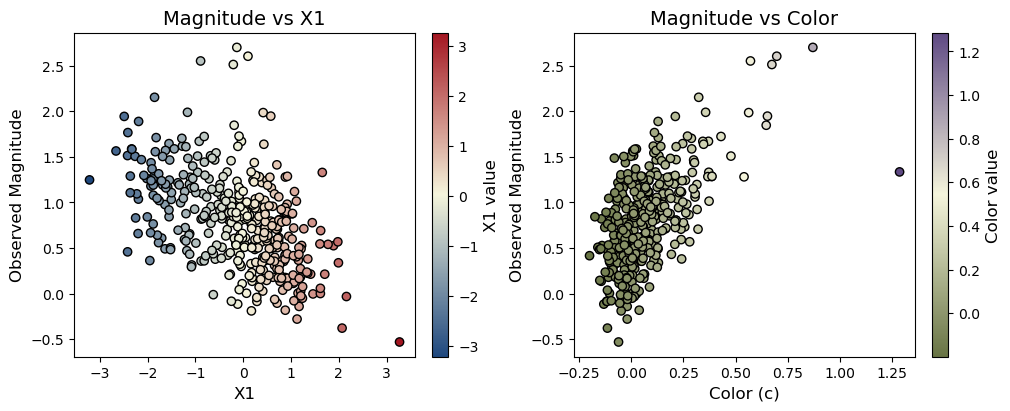

In [7]:
index = 5  # index for your data slice

# Define the color maps
cmap1 = LinearSegmentedColormap.from_list(
    'custom_red_beige_blue',
    ['#1F487E', 'beige', '#A31621']
)

cmap2 = LinearSegmentedColormap.from_list(
    'custom_green_beige_purple',
    ['#687444', 'beige', '#5E4983']
)

# Create figure and horizontal subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# First subplot: x1 vs magobs
sc1 = axes[0].scatter(data_filt['x1'][index, :], data_filt['magobs'][index, :], c=data_filt['x1'][index, :], cmap=cmap1, edgecolor='k')
axes[0].set_title('Magnitude vs X1', fontsize=14)
axes[0].set_xlabel('X1', fontsize=12)
axes[0].set_ylabel('Observed Magnitude', fontsize=12)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('X1 value', fontsize=12)

# Second subplot: c vs magobs
sc2 = axes[1].scatter(data_filt['c'][index, :], data_filt['magobs'][index, :], c=data_filt['c'][index, :], cmap=cmap2, edgecolor='k')
axes[1].set_title('Magnitude vs Color', fontsize=14)
axes[1].set_xlabel('Color (c)', fontsize=12)
axes[1].set_ylabel('Observed Magnitude', fontsize=12)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Color value', fontsize=12)

plt.show()


# Prepare train and test sets

## Set bounds

In [8]:
bounds = {
    name: {
        'min': float(jnp.round(jnp.min(values), 1)),
        'max': float(jnp.round(jnp.max(values), 1))
    }
    for name, values in params.items()
}

## Label data

In [9]:
K = len(params)  # number of parameters

key, lhs_key = jax.random.split(key)
lhs_samples = nntr.lhs_jax(lhs_key, K, N)   # shape (N, K)

# Convert bounds to arrays
param_names = list(params.keys())
mins = jnp.array([bounds[name]['min'] for name in param_names])
maxs = jnp.array([bounds[name]['max'] for name in param_names])

false_params = mins + (maxs - mins) * lhs_samples  # shape (N,K)

# Masking: produce N×K array of masked parameters
key, label_key = jax.random.split(key)
label_mask = jax.random.uniform(label_key, (N,)) > 0.5  # (N,)

param_true = jnp.stack([params[name] for name in param_names], axis=1)  # (N,K)
param_masked = jnp.where(label_mask[:, None], param_true, false_params)  # (N,K)

## Concatenate data

In [10]:
# -----------------------------
# 1. Prepare data arrays
# -----------------------------
data_names = list(data_padded.keys())        # list of C "columns"
n_cols = len(data_names)                     # number of features per element

# Create a list of (N, M) arrays
data_arrays = [data_padded[name] for name in data_names]

# Concatenate along last axis to form (N, M*n_cols)
data_concat = jnp.concatenate(data_arrays, axis=-1)

# Ensure mask and parameters are in the correct shape
inputs = jnp.concatenate([data_concat, mask, param_masked], axis=-1)

# Output labels
outputs = label_mask.astype(jnp.int32)[:, None]

print("Input shape:", inputs.shape)    # (N, M*n_cols + M + n_params)
print("Output shape:", outputs.shape)  # (N, 1)

# -----------------------------
# 2. Split train/test
# -----------------------------
key, split_key = jax.random.split(key)
train_data, test_data, train_labels, test_labels = nntr.train_test_split_jax(
    inputs, outputs, test_size=0.3, shuffle=True, key=split_key
)

# Move to device
train_data = jax.device_put(train_data)
train_labels = jax.device_put(train_labels)
test_data = jax.device_put(test_data)
test_labels = jax.device_put(test_labels)

print("Train/test split done. Shapes:")
print("train_data:", train_data.shape)
print("train_labels:", train_labels.shape)
print("test_data:", test_data.shape)
print("test_labels:", test_labels.shape)


Input shape: (10000, 4404)
Output shape: (10000, 1)
Train/test split done. Shapes:
train_data: (7000, 4404)
train_labels: (7000, 1)
test_data: (3000, 4404)
test_labels: (3000, 1)


# Build a neural network

In [11]:
# Define the size of the different network layers
Nsize_p = 128 #64 #128
Nsize_r =  2048 #1024 #2048

n_cols = len(data_names)
print(n_cols)
n_params = len(param_names)
print(n_params)

model_config = {
    'Nsize_p': Nsize_p,
    'Nsize_r': Nsize_r
}

model = nntr.DeepSetClassifier(0.05, Nsize_p, Nsize_r, n_cols, n_params, rngs=nnx.Rngs(0))

# Visualize the model structure
nnx.display(model)

10
4


In [12]:
# Initialise metrics history
metrics_history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [], 'test_accuracy': []}

In [13]:
# Define the learning rate schedule
learning_rate_schedule = optax.exponential_decay(
    init_value=3e-4,
    transition_steps=1000,  # Decay every 1000 forward passes
    decay_rate=0.9,
)

momentum = 0.9 # Necessary for the Adam optimiser

# Initialize optimiser with the adaptive learning rate
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate_schedule, momentum))

# Train NN

In [14]:
print(train_data.device)
print(train_labels.device)

METAL:0
METAL:0


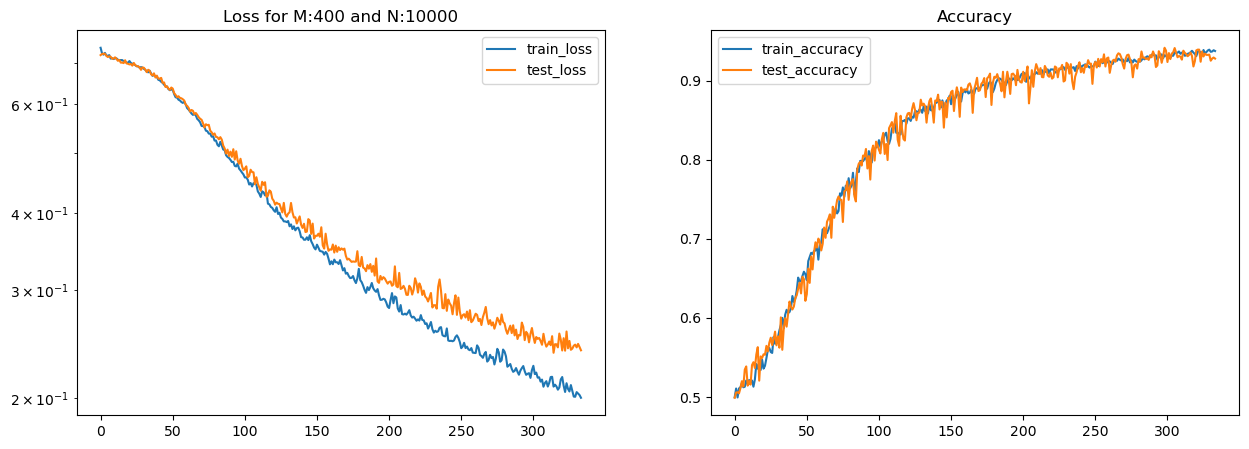


 Early stopping at epoch 322 due to 20 consecutive increases in loss gap 



In [16]:
# Early stopping parameters
patience = 20 # Number of epochs to wait for improvement
epochs = 1000 # Maximum number of epochs

batch_size = N//20 #min(N//10, 1000)

# Initialise stopping criteria
best_train_loss = jnp.inf
best_test_loss = jnp.inf
strikes = 0

model.train()
for epoch in range(epochs):
    # Shuffle the training data using JAX.
    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, len(train_data))
    train_data = train_data[perm]
    train_labels = train_labels[perm]
    del perm
    
    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_train_total = 0
    
    for i in range(0, len(train_data), batch_size):
        # Get the current batch of data and labels
        batch_data = train_data[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        
        # Perform a training step
        loss, _ = nntr.loss_fn(model, (batch_data, batch_labels))
        accuracy = nntr.accuracy_fn(model, (batch_data, batch_labels))
        epoch_train_loss += loss
        # Multiply batch accuracy by batch size to get number of correct predictions
        epoch_train_correct += accuracy * len(batch_data)
        epoch_train_total += len(batch_data)
        nntr.train_step(model, optimizer, (batch_data, batch_labels))
    
    # Log the training metrics.
    current_train_loss = epoch_train_loss / (len(train_data) / batch_size)
    metrics_history['train_loss'].append(current_train_loss)
    # Compute overall epoch accuracy
    metrics_history['train_accuracy'].append(epoch_train_correct / epoch_train_total)

    epoch_test_loss = 0
    epoch_test_correct = 0
    epoch_test_total = 0

    # Compute the metrics on the test set using the same batching as training
    for i in range(0, len(test_data), batch_size):
        batch_data = test_data[i:i+batch_size]
        batch_labels = test_labels[i:i+batch_size]

        loss, _ = nntr.loss_fn(model, (batch_data, batch_labels))
        accuracy = nntr.accuracy_fn(model, (batch_data, batch_labels))
        epoch_test_loss += loss
        epoch_test_correct += accuracy * len(batch_data)
        epoch_test_total += len(batch_data)

    # Log the test metrics.
    current_test_loss = epoch_test_loss / (len(test_data) / batch_size)
    metrics_history['test_loss'].append(current_test_loss)
    metrics_history['test_accuracy'].append(epoch_test_correct / epoch_test_total)
    
    # Early Stopping Check
    if current_test_loss < best_test_loss:
        best_test_loss = current_test_loss  # Update best test loss
        strikes = 0
    elif current_train_loss >= best_train_loss:
        strikes = 0
    elif current_test_loss > best_test_loss and current_train_loss < best_train_loss:
        strikes +=1
    elif current_train_loss < best_train_loss:
        best_train_loss = current_train_loss # Update best train loss

    if strikes >= patience:
        print(f"\n Early stopping at epoch {epoch+1} due to {patience} consecutive increases in loss gap \n")
        break

    if epoch%1 == 0:
        #Plot loss and accuracy in subplots
        clear_output(wait=True) # Clear the output to avoid cluttering
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.set_title(f'Loss for M:{M} and N:{N}')
        for dataset in ('train', 'test'):
            ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
            ax1.legend()
            ax1.set_yscale("log")
    
        ax2.set_title('Accuracy')
        for dataset in ('train', 'test'):
            ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
            ax2.legend()
        plt.show()

# Test NN

## Test Accuracy

In [17]:
model.eval()  # disable dropout, etc.

batch_size = 128  # tune this to fit your RAM; lower → safer

# Accumulators
all_logits = []
all_labels = []

# Loop over your test set in-place
num_samples = test_data.shape[0]
for i in range(0, num_samples, batch_size):
    xb = test_data[i : i + batch_size]
    yb = test_labels[i : i + batch_size]

    # Get logits for this mini-batch
    logits = nntr.pred_step(model, xb)
    all_logits.append(logits)

    # Store the corresponding true labels
    all_labels.append(yb > 0.5)

# Merge everything back together
all_logits = jnp.concatenate(all_logits, axis=0)
all_preds  = jsp.special.expit(all_logits) > 0.5
all_labels = jnp.concatenate(all_labels, axis=0)

# === same metrics computation as before ===
TP = jnp.sum((all_preds == 1) & (all_labels == 1))
TN = jnp.sum((all_preds == 0) & (all_labels == 0))
FP = jnp.sum((all_preds == 1) & (all_labels == 0))
FN = jnp.sum((all_preds == 0) & (all_labels == 1))

print(f"True positives : {TP}")
print(f"True negatives : {TN}")
print(f"False positives: {FP}")
print(f"False negatives: {FN}\n")

accuracy    = (TP + TN) / (TP + TN + FP + FN)
precision   = TP / (TP + FP)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy   : {accuracy:.3f}")
print(f"Precision  : {precision:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

True positives : 1468
True negatives : 1282
False positives: 226
False negatives: 24

Accuracy   : 0.917
Precision  : 0.867
Sensitivity: 0.984
Specificity: 0.850


## Test TARP

In [18]:
# ========== Run TARP test ==========
model.eval()

param_names = list(bounds.keys())
NDIM = len(param_names)
BOUNDS = jnp.array([[bounds[name]['min'], bounds[name]['max']] for name in param_names])


# Select samples with true parameters in the test set
# indices = jnp.where(test_labels)[0]
mask_true = test_labels[:, 0] == 1
xy_test = test_data[mask_true, :-NDIM]
theta_star = test_data[mask_true, -NDIM:]
# xy_test = test_data[test_labels, :-NDIM]

# theta_test = test_data[indices, -NDIM:]

# N_sims = int(jnp.minimum(200, indices.shape[0]))
N_sims = int(jnp.minimum(500, jnp.sum(test_labels)))
xy_test = xy_test[:N_sims, :]
theta_star = theta_star[:N_sims, :]

# theta_test = theta_test[:N_sims, :]
# theta_test: center of prior bounds, repeated for each sample
# theta_center = (BOUNDS[:, 0] + BOUNDS[:, 1]) / 2.0  # shape (NDIM,)
# theta_test = jnp.repeat(theta_center[None, :], xy_test.shape[0], axis=0)  # shape (N, NDIM)

In [ ]:
alpha_grid = jnp.linspace(0, 1, 50)

print("Launching MCMC (JIT‐compiled) on CPU...")
with jax.default_device(cpu):
    ecp, post, key = nnte.compute_ecp_tarp_jitted_with_progress(
        model, xy_test, theta_star, alpha_grid, 200, 200, key, BOUNDS
    )
print("MCMC finished")

Launching MCMC (JIT‐compiled) on CPU...


Computing ECP batches:   0%|          | 0/25 [00:00<?, ?it/s]

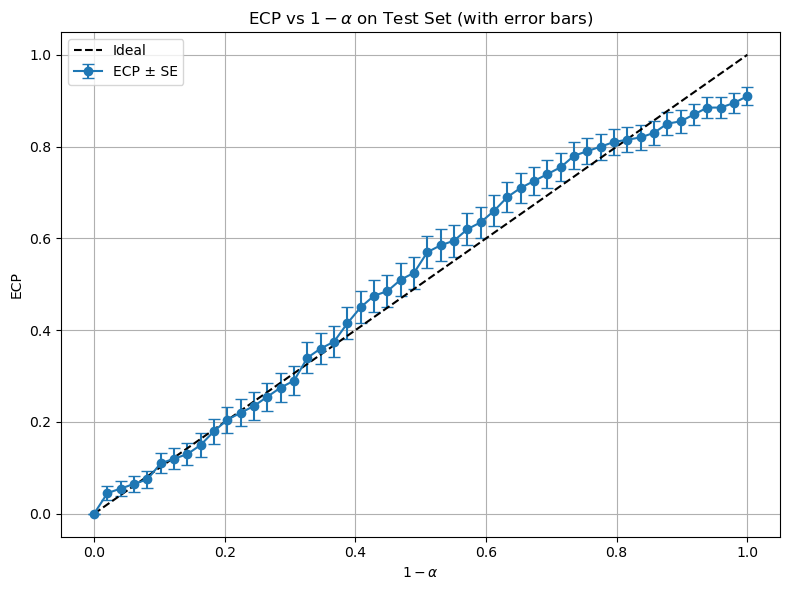

In [ ]:
# Example: 1 - alpha grid and computed ecp
alpha_grid = jnp.array(alpha_grid)
ecp = jnp.array(ecp)

# Compute standard error for binomial proportion
se = jnp.sqrt(ecp * (1 - ecp) / N_sims) #https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wald_interval

# CHECK HOW TO COMPUTE THE ERROR

# Plot with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(1 - alpha_grid, ecp, yerr=se, fmt='o-', capsize=4, label='ECP ± SE')
plt.plot([0, 1], [0, 1], 'k--', label='Ideal')
plt.xlabel(r'$1 - \alpha$')
plt.ylabel("ECP")
plt.title("ECP vs $1 - \\alpha$ on Test Set (with error bars)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Save NN to disk

In [ ]:
# Save the trained model for future use
nntr.save_nn(model,'../data/NNs/nn_model', model_config)